In [1]:
#Import standard packages for model training

import sklearn as SK
import lightgbm as lgb
from sklearn.metrics import *
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import *
from skopt import BayesSearchCV
import numpy as np
import pandas as pd
import scipy.stats
from math import sqrt
import os 
import io
from tensorboard.plugins.hparams import api as hp
from utils import utils

commons = utils.Commons()
ts_helper = utils.TS_Helper()
shap_helper = utils.Shap_Helper()
ml_helper = utils.ML_Helper()
ml_helper.model_type = ml_helper.Classification
ts_helper.model_type = ts_helper.Classification
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "-1"

In [2]:
#Inport train, validation and test sets

training = './data/Classification/Tb.brucei/scaffold_split/train_fold_4.csv'
validation = './data/Classification/Tb.brucei/scaffold_split/valid_fold_4.csv'
test = './data/Classification/Tb.brucei/scaffold_split/test_fold_4.csv'
TASK_START = 2
NUM_TASKS = 1
SMILES = 'SMILES'
train_dataset,y_train,train_smiles = commons.load_dataset(training,SMILES,TASK_START,NUM_TASKS)
valid_dataset,y_val,val_smiles = commons.load_dataset(validation,SMILES,TASK_START,NUM_TASKS)
test_dataset,y_test,test_smiles = commons.load_dataset(test,SMILES,TASK_START,NUM_TASKS)

train_dataset.head()

Loaded dataset ./data/Classification/Tb.brucei/scaffold_split/train_fold_4.csv with shape: (1051, 3)
Loaded dataset ./data/Classification/Tb.brucei/scaffold_split/valid_fold_4.csv with shape: (132, 3)
Loaded dataset ./data/Classification/Tb.brucei/scaffold_split/test_fold_4.csv with shape: (131, 3)


,ID,SMILES,Tb.brucei
0,1049,CCN1N=C(C=C1C)C(=O)NC1=NN=C(CCSC2=CC=CC=C2)O1,0
1,798,CC1=CC=CC(NC2=NC(NC3=CC=C4OCOC4=C3)=NC(=N2)N2C...,1
2,1155,COC1=CC=C(CCNC(=O)NCC2CN(C(=O)C2)C2=CC=C(Cl)C=...,0
3,204,CC1OC(C(O)C(O)C1O)N1C=C(CNC2=CC3=C4C(=CC=C5C(=...,1
4,206,CN(C)CCCN1C(=O)C2=CC(NCC3=CN(N=N3)C3OC(CO)C(O)...,1


In [3]:
# calculate ECFP (defaut) fingerprints using RDKit
RADIUS = 2 #diameter 4
FP_SIZE = 2048  #bit string size
FEAT = False #used when you consider pharmacophoric features
X_train = commons.assing_fp(train_smiles,FP_SIZE,RADIUS,FEAT)
X_test = commons.assing_fp(test_smiles,FP_SIZE,RADIUS,FEAT)

y_train = y_train.ravel()
y_train = np.array(y_train).astype(int)
y_test = y_test.ravel()
y_test = np.array(y_test).astype(int)

X_train.shape, X_test.shape

((1051, 2048), (131, 2048))

In [4]:
# parameters for train model

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scorer = make_scorer(mean_squared_error)

# log-uniform: understand as search over p = exp(x) by varying x

best_model = BayesSearchCV(lgb.LGBMClassifier(),                   
    {
    'learning_rate': (0.01, 0.1, 'uniform'), 
    'num_leaves': (1, 15),
    'n_estimators': (2, 50), 
    'max_depth': (1, 10),
    'subsample': (0.1, 0.3), 
    }, 
    n_iter=1, # Number of parameter settings that are sampled
    cv=cv,
    scoring = scorer,
    refit = True, # Refit the best estimator with the entire dataset.
    random_state=42,
    n_jobs = -1
)

best_model.fit(X_train, y_train)

print("Best parameters: %s" % best_model.best_params_)

Best parameters: OrderedDict([('learning_rate', 0.04690935629679825), ('max_depth', 8), ('n_estimators', 47), ('num_leaves', 5), ('subsample', 0.23402958965378692)])


In [5]:
#Fit model using best hyperparameters

model = lgb.LGBMClassifier(**best_model.best_params_)
model.probablity = True
model.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.04690935629679825, max_depth=8, n_estimators=47,
               num_leaves=5, subsample=0.23402958965378692)

Confusion matrix: [[479 156]
 [ 89 327]]
Statistic       Value
-----------  --------
Accuracy     0.766889
Precision    0.677019
Recall       0.786058
F1           0.727475
MCC          0.530264
Kappa        0.525786
SE           0.786058
SP           0.754331
PPV          0.677019
NPV          0.84331
TPR          0.786058
FPR          0.245669
[[479 156]
 [ 89 327]]


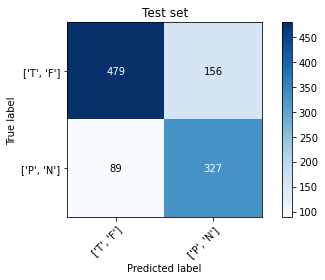

Confusion matrix: [[44 29]
 [10 48]]
Statistic       Value
-----------  --------
Accuracy     0.70229
Precision    0.623377
Recall       0.827586
F1           0.711111
MCC          0.434241
Kappa        0.416314
SE           0.827586
SP           0.60274
PPV          0.623377
NPV          0.814815
TPR          0.827586
FPR          0.39726
[[44 29]
 [10 48]]


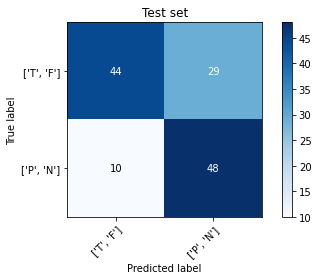

In [6]:
#Statistical characteristics of model

ml_helper.get_ML_StatsForNSplits(model,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test)
